In [12]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as Func
from datetime import datetime
from torchvision.io import read_image
import scipy.linalg


In [22]:
def load_class_info(yaml_file):
    with open(yaml_file, 'r') as file:
            class_info = yaml.safe_load(file)
    return class_info['classes']

def generate_ecc_codes(num_classes, code_length=None):
    hadamard_size = 1
    while hadamard_size < num_classes:
        hadamard_size *= 2

    # Generate the Hadamard matrix
    M = scipy.linalg.hadamard(hadamard_size).astype(np.float32)
    print("Scipy hadamard ", M.shape)
    
    # Replace the first column for every second row
    M[np.arange(0, hadamard_size, 2), 0] = -1
    print("Replaced ", M.shape)
    
    # Shuffle the rows and columns
    np.random.seed(12754)
    np.random.shuffle(M)
    idx = np.random.permutation(hadamard_size)
    
    # Select the required number of rows and columns
    M = M[0:num_classes, idx[0:code_length]]
    
    return M
    
def label_transform_ecc(classes, labels, codewords):
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    
    if not isinstance(codewords, (list, np.ndarray)):
        raise ValueError("codewords should be a list or numpy array")
    
    if len(codewords) == 0 or not isinstance(codewords[0], (list, np.ndarray)):
        raise ValueError("codewords should be a non-empty list of lists or 2D numpy array")
    
    codeword_length = len(codewords[0])
    target = np.zeros(codeword_length, dtype=int)
    
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            if index < len(codewords):
                target = codewords[index]
            else:
                print(f"Warning: Index {index} is out of range for codewords")
    
    return target

def ecc_encode(label, ecc_codes):
    class_index = label.index(1)  # Assuming label is initially one-hot
    return ecc_codes[class_index]
    
def transform(image, keypoints, one_hot_label, num_classes, image_size=(224, 224), fusion='concat'):
    transform_ops = transforms.Compose([
        transforms.Resize(image_size),
    ])
    image = transform_ops(image)
    keypoints = torch.tensor(keypoints).float()
    one_hot_label = torch.tensor(one_hot_label).float()
    one_hot_channel = one_hot_label.unsqueeze(1).unsqueeze(2).expand(len(one_hot_label), image_size[0], image_size[1])
    one_hot_channel = one_hot_channel.sum(dim=0, keepdim=True)
    
    input_combined = torch.cat((image, one_hot_channel), dim=0)

    if fusion == 'concat':
        input_combined = torch.cat((image, one_hot_channel), dim=0)

    elif fusion == 'add':
        if image.shape[0] == 3:
            padding = torch.zeros_like(image[0]).unsqueeze(0)
            padded_one_hot_channel = torch.cat([one_hot_channel, padding, padding], dim=0)
        input_combined = image + padded_one_hot_channel

    elif fusion == 'multiply':
        if image.shape[0] == 3:
            one_hot_channel = one_hot_channel.repeat(3, 1, 1)
        input_combined = image * one_hot_channel
        
    if fusion == 'concat':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
    else:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    input_combined = normalize(input_combined)
    
    return input_combined, keypoints

def denormalize_image(image):
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    return image

def visualize_keypoints(image, keypoints):
    image = denormalize_image(image)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.show()

In [23]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, codeWords=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.codeWords = codeWords
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.codeWords)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original
    

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))


class_config_path = '../../config/formated_class.yaml'
KEYPOINTS_FOLDER_TRAIN = '../../dataset/robocup_all_test/'
train_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"train/")
val_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"val/")

num_classes = len(load_class_info(class_config_path))
codewords = generate_ecc_codes(num_classes, 16)
    
fusion_type = 'concat'
# fusion_type = 'add'
# fusion_type = 'multiply'

train_dataset = ClassDataset(train_path, class_config_path, transform=transform, label_transform=label_transform_ecc, codeWords=codewords, fusion_type=fusion_type)
valid_dataset = ClassDataset(val_path, class_config_path, transform=transform, label_transform=label_transform_ecc, codeWords=codewords, fusion_type=fusion_type)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

Scipy hadamard  (32, 32)
Replaced  (32, 32)


concatenated input size =  torch.Size([4, 224, 224])
keypoint = tensor([[489.0000, 229.5000]])
label = tensor([ 1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1])


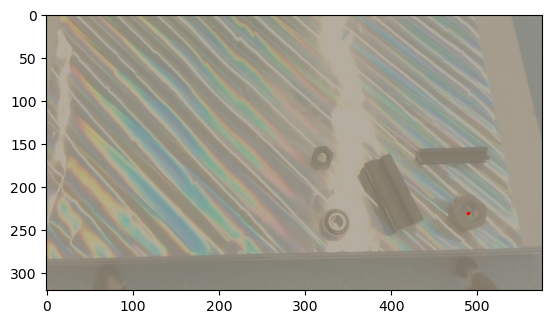

In [29]:
iterator = iter(valid_loader)
images, targets, img = next(iterator)
image_number = 0
num_channels = images[image_number].shape[0]

print("concatenated input size = ", images[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")

visualize_keypoints(img[image_number], targets[image_number]['keypoints'])

In [30]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1, num_channels=4): 
        super(CustomResNet18, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet18.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet18.fc.in_features, self.num_keypoints * 2)
        self.resnet18.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet18(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

In [31]:
def train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    key_train_losses = []
    key_valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, labels in train_loader:
            labels = [target['labels'].to(device) for target in targets]
            images = torch.stack(images).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)

            optimizer.zero_grad()

            class_outputs, keypoint_outputs = model(images)
            
            loss_cls = criterion_cls(class_outputs, class_indices)
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
            total_loss = loss_kpt + loss_cls # Combine losses for backpropagation
            total_loss.backward()
            optimizer.step()
            total_train_loss += loss_cls.item()
            total_kpt_loss += loss_kpt.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kpt_loss = total_kpt_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Train Keypoint Loss: {avg_kpt_loss}')

        model.eval()
        total_val_loss = 0.0
        total_val_kpt_loss = 0.0

        with torch.no_grad():
            for images, targets, labels in valid_loader:
                labels = [target['labels'].to(device) for target in targets]
                images = torch.stack(images).to(device)
                ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

                labels_tensor = torch.stack(labels)
                class_indices = torch.argmax(labels_tensor, dim=1)

                class_outputs, keypoint_outputs = model(images)
                
                loss_cls = criterion_cls(class_outputs, class_indices)
                loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
                # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
                
                total_val_loss += loss_cls.item() 
                total_val_kpt_loss += loss_kpt.item()

        avg_val_loss = total_val_loss / len(valid_loader.dataset)
        avg_val_kpt_loss = total_val_kpt_loss / len(valid_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Val Keypoint Loss: {avg_val_kpt_loss}')
        
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        key_train_losses.append(avg_kpt_loss)
        key_valid_losses.append(avg_val_kpt_loss)

    return model, train_losses, key_train_losses, valid_losses, key_valid_losses  # Optionally return the model

In [32]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
iterator = iter(valid_loader)
combined_input, targets, img = next(iterator)
image_number = 0

num_channels = combined_input[image_number].shape[0]
num_classes = len(load_class_info(class_config_path))
model = CustomResNet18(num_classes=num_classes, num_keypoints=1, num_channels=num_channels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion_cls = nn.CrossEntropyLoss()
criterion_kpt = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
epochs_train = 100
trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=epochs_train)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), './models/resnet18_conditional_concat_test.pth')

Epoch 1/100, Training Loss: 0.03459184410381111, Train Keypoint Loss: 3052.852276954816
Epoch 1/100, Validation Loss: 0.02950625057364332, Val Keypoint Loss: 2910.6518386314656


KeyboardInterrupt: 

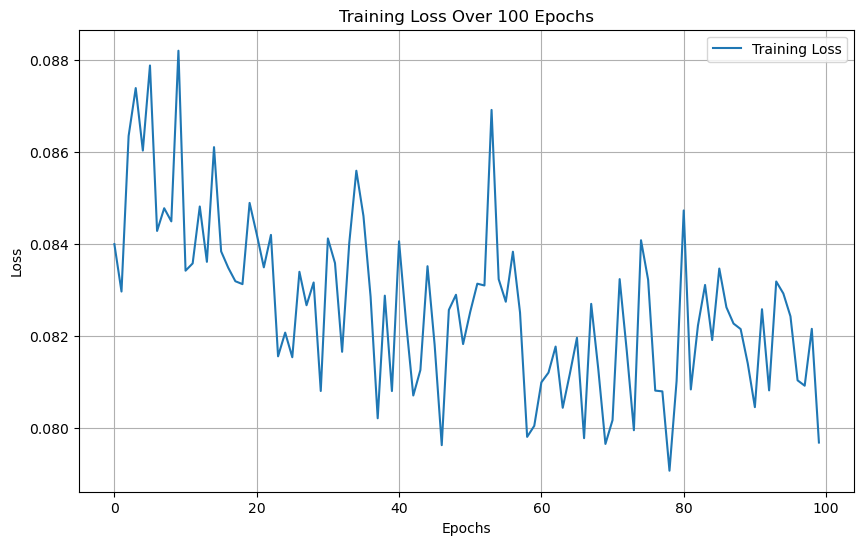

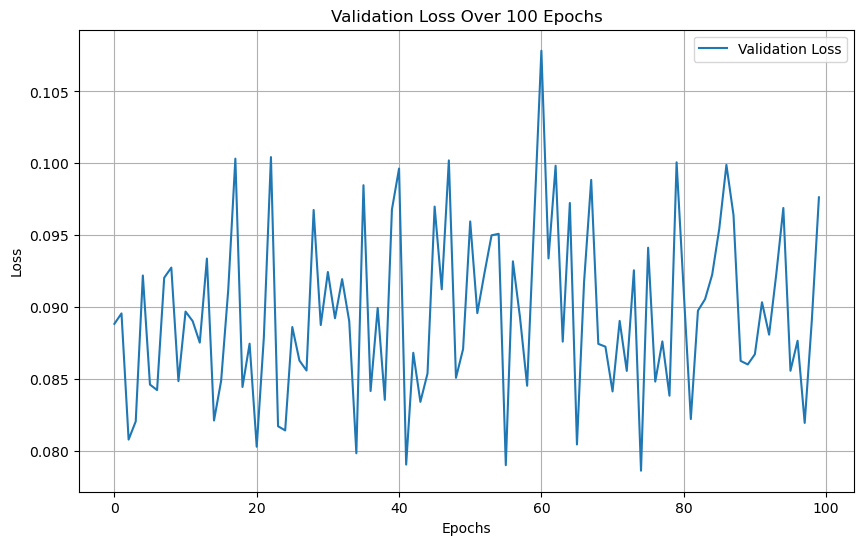

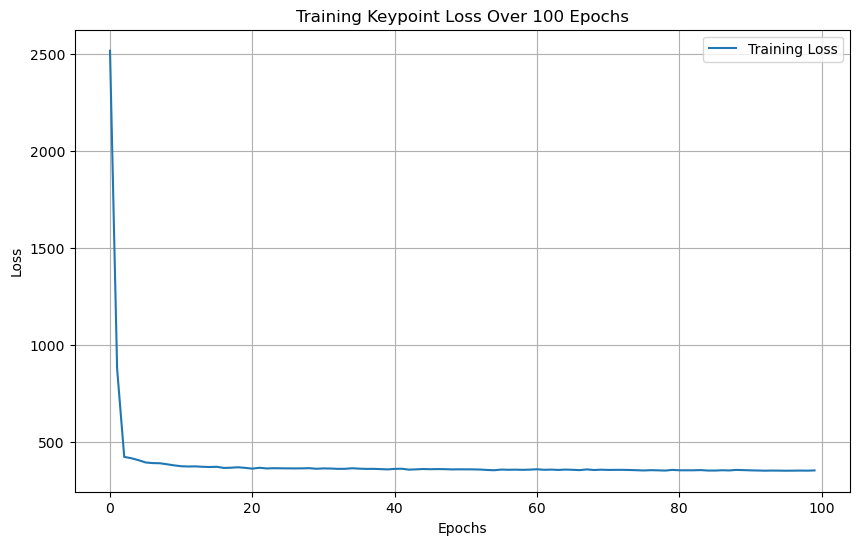

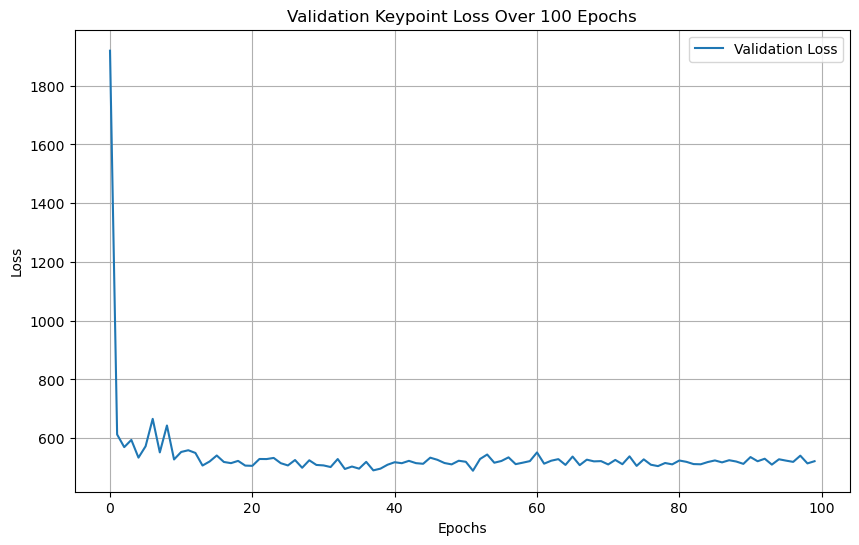

In [102]:
def plot_train_losses(train_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_losses(valid_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_train_kpt_losses(train_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_kpt_losses, label='Training Loss')
    plt.title('Training Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_kpt_losses(val_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(val_kpt_losses, label='Validation Loss')
    plt.title('Validation Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

path_train_loss = "./plots/train_losses_resnet18_conditional_"+fusion_type+"_2.png"
path_val_loss = "./plots/val_losses_resnet18_conditional_add_"+fusion_type+"_2.png"
path_train_kpt = "./plots/train_kpt_losses_resnet18_conditional_"+fusion_type+"_2.png"
path_val_kpt = "./plots/val_kpt_losses_resnet18_conditional_"+fusion_type+"_2.png"

plot_train_losses(train_loss, save_path=path_train_loss)
plot_val_losses(val_loss, save_path=path_val_loss)
plot_train_kpt_losses(key_train_loss, save_path=path_train_kpt)
plot_val_kpt_losses(key_val_loss, save_path=path_val_kpt)